In [2]:
# =========================================
# 1. Mount Google Drive and unzip AffectNet
# =========================================

import numpy as np

from google.colab import drive
drive.mount('/content/drive')

import zipfile, os

zip_path = '/content/drive/MyDrive/affectnet.zip'  # update path if needed
extract_path = '/content/affectnet'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# =========================================
# 2. Install requirements
# =========================================
!pip install -q tqdm seaborn

# =========================================
# 3. Imports
# =========================================
import torch, torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================================
# 4. Dataset Class with YOLO cropping
# =========================================
class AffectNetDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = sorted([
            f for f in os.listdir(images_dir)
            if f.endswith('.jpg') or f.endswith('.png')
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        label_path = os.path.join(self.labels_dir, img_name.replace('.jpg', '.txt').replace('.png', '.txt'))

        image = Image.open(img_path).convert('RGB')
        width, height = image.size

        # Parse YOLO label
        with open(label_path, 'r') as f:
            line = f.readline().strip()
            parts = line.split()
            class_id = int(parts[0])
            x_center = float(parts[1]) * width
            y_center = float(parts[2]) * height
            box_width = float(parts[3]) * width
            box_height = float(parts[4]) * height

            left = int(x_center - box_width / 2)
            top = int(y_center - box_height / 2)
            right = int(x_center + box_width / 2)
            bottom = int(y_center + box_height / 2)

            image = image.crop((left, top, right, bottom))

        if self.transform:
            image = self.transform(image)

        return image, class_id

# =========================================
# 5. Transforms with data augmentation
# =========================================
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# =========================================
# 6. Paths
# =========================================
base_path = '/content/affectnet/YOLO_format'
train_images = f'{base_path}/train/images'
train_labels = f'{base_path}/train/labels'
valid_images = f'{base_path}/valid/images'
valid_labels = f'{base_path}/valid/labels'
test_images = f'{base_path}/test/images'
test_labels = f'{base_path}/test/labels'

# =========================================
# 7. Load datasets
# =========================================
train_dataset = AffectNetDataset(train_images, train_labels, transform)
valid_dataset = AffectNetDataset(valid_images, valid_labels, transform)
test_dataset = AffectNetDataset(test_images, test_labels, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# =========================================
# 8. Model (ResNet50) + Smoothing
# =========================================
num_classes = 8  # update if needed
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)






Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# =========================================
# 9. Train/Eval functions with tqdm
# =========================================
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_correct = 0, 0
    for x, y in tqdm(loader, desc='Training', leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        total_correct += (out.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

def eval_model(model, loader, criterion, return_preds=False):
    model.eval()
    total_loss, total_correct = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            total_loss += loss.item() * x.size(0)
            total_correct += (out.argmax(1) == y).sum().item()

            if return_preds:
                all_preds.append(out.argmax(1).cpu().numpy())
                all_labels.append(y.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    avg_acc = total_correct / len(loader.dataset)

    if return_preds:
        return avg_loss, avg_acc, np.concatenate(all_preds), np.concatenate(all_labels)
    else:
        return avg_loss, avg_acc




In [4]:
# Just check basic two-return version
val_loss, val_acc = eval_model(model, valid_loader, criterion)
print(val_loss, val_acc)

# Check extended version with predictions
test_loss, test_acc, y_pred, y_true = eval_model(model, test_loader, criterion, return_preds=True)
print(test_loss, test_acc, y_pred[:5], y_true[:5])


2.107791263440605 0.13503514613392525
2.107431876464678 0.13176043557168785 [5 4 5 4 7] [5 1 4 4 4]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]



Epoch 1/30


Train Loss: 1.2073 | Acc: 0.5430 | Val Loss: 0.8964 | Acc: 0.6639
✅ Saved best model with val acc: 0.6639

Epoch 2/30


Train Loss: 0.8494 | Acc: 0.6828 | Val Loss: 0.8659 | Acc: 0.6724
✅ Saved best model with val acc: 0.6724

Epoch 3/30


Train Loss: 0.7288 | Acc: 0.7252 | Val Loss: 0.7803 | Acc: 0.7007
✅ Saved best model with val acc: 0.7007

Epoch 4/30


Train Loss: 0.6390 | Acc: 0.7638 | Val Loss: 0.7569 | Acc: 0.7157
✅ Saved best model with val acc: 0.7157

Epoch 5/30


Train Loss: 0.5703 | Acc: 0.7880 | Val Loss: 0.8853 | Acc: 0.6926

Epoch 6/30


Train Loss: 0.5027 | Acc: 0.8150 | Val Loss: 0.8000 | Acc: 0.7077

Epoch 7/30


Train Loss: 0.4544 | Acc: 0.8312 | Val Loss: 0.8629 | Acc: 0.7022
⚠️ Early stopping triggered after 3 epochs without improvement.

✅ Training Done in 17.88 minutes


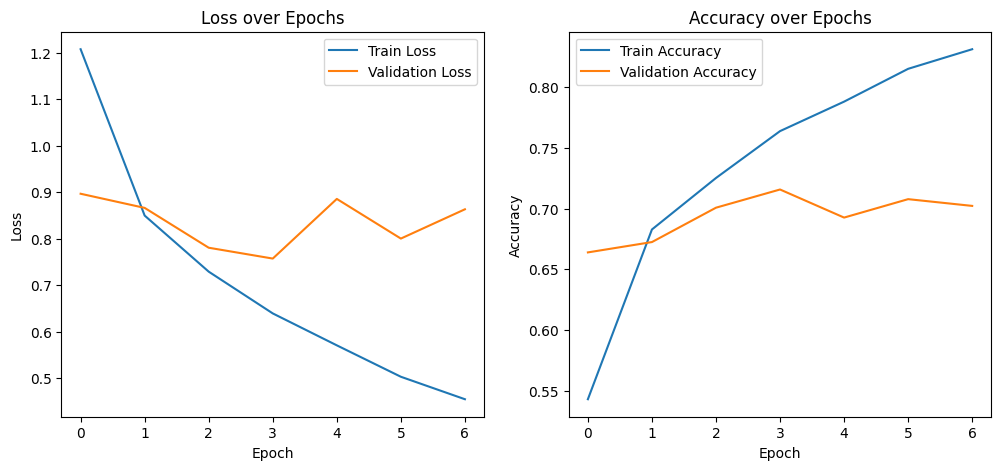

In [6]:
from tqdm import tqdm
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt

# Data augmentation transforms for training, simple for validation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Update datasets
train_dataset = AffectNetDataset(train_images, train_labels, train_transform)
valid_dataset = AffectNetDataset(valid_images, valid_labels, valid_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2)

# Model setup
num_classes = 8
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train function with tqdm
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_correct = 0, 0
    loop = tqdm(loader, desc='Training', leave=False)
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (out.argmax(1) == y).sum().item()

        loop.set_postfix(loss=loss.item(), accuracy=total_correct / ((loop.n + 1) * loader.batch_size))
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

# Eval function with tqdm
def eval_model(model, loader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0
    loop = tqdm(loader, desc='Evaluating', leave=False)
    with torch.no_grad():
        for x, y in loop:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            total_loss += loss.item() * x.size(0)
            total_correct += (out.argmax(1) == y).sum().item()

            loop.set_postfix(loss=loss.item(), accuracy=total_correct / ((loop.n + 1) * loader.batch_size))
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

# Early stopping and training loop
patience = 3
best_val_acc = 0
epochs_no_improve = 0
best_model_path = "/content/drive/MyDrive/best_affectnet_model.pth"

train_losses, train_accs = [], []
val_losses, val_accs = [], []

start_time = time.time()
epochs = 30

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = eval_model(model, valid_loader, criterion)

    scheduler.step()

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Saved best model with val acc: {best_val_acc:.4f}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"⚠️ Early stopping triggered after {patience} epochs without improvement.")
            break

print(f"\n✅ Training Done in {(time.time() - start_time)/60:.2f} minutes")

# Plot accuracy and loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()



🧪 Test Loss: 0.8339 | Test Accuracy: 0.6933

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       383
           1       0.69      0.68      0.68       332
           2       0.66      0.61      0.63       327
           3       0.75      0.75      0.75       318
           4       0.86      0.88      0.87       399
           5       0.51      0.63      0.56       250
           6       0.60      0.54      0.57       278
           7       0.73      0.70      0.71       468

    accuracy                           0.69      2755
   macro avg       0.68      0.68      0.68      2755
weighted avg       0.70      0.69      0.69      2755



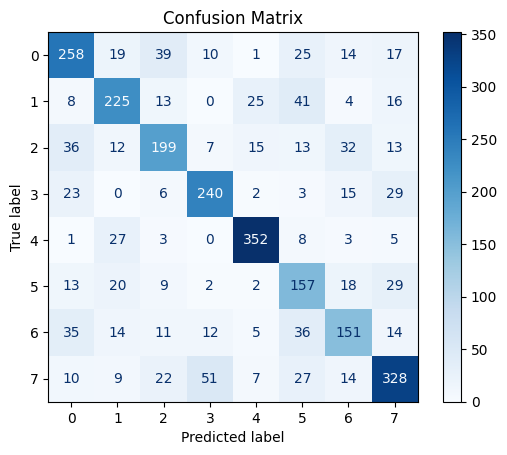

In [8]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Load best saved model weights
best_model_path = "/content/drive/MyDrive/best_affectnet_model.pth"
model.load_state_dict(torch.load(best_model_path))
model.eval()

# 2. Define quick test evaluation function (returns preds and labels)
def test_evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0
    y_pred = []
    y_true = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            total_correct += (out.argmax(1) == y).sum().item()

            y_pred.extend(out.argmax(1).cpu().numpy())
            y_true.extend(y.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    accuracy = total_correct / len(loader.dataset)
    return avg_loss, accuracy, y_pred, y_true

# 3. Run test evaluation
test_loss, test_acc, y_pred, y_true = test_evaluate(model, test_loader, criterion)
print(f"\n🧪 Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# 4. Classification report and confusion matrix plot
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
